# BAYESIAN COIN TOSS WITH `pymc`

## Some imports

In [1]:
import pymc
import seaborn           as sbn
import matplotlib.pyplot as plt
import numpy             as np

from pymc.Matplot              import plot as mcplot
from IPython.display           import Image
from scipy.stats.distributions import beta as beta_dist

## Notebook settings

In [2]:
%matplotlib notebook
sbn.set_style('whitegrid')

## Generate data

In [3]:
n_samples = 100  # The number of times you toss the coin
true_prob = 0.3  # The probability it comes up heads

data  = pymc.rbernoulli(true_prob, size=n_samples)

## Define your _prior_ belief on the probability $p$ to get heads ...
... in terms of a Beta($\alpha$, $\beta$)-distribution. For example, $\alpha=\beta=1$ specifies a _uniform_ distribution of $p$ over the intervall $[0, 1]$, whereas $\alpha=\beta=\frac{1}{2}$ specifies no prior (Fisher) _information_ on $p$.

In [4]:
alpha = 0.5     # alpha-parameter of the Beta-prior
beta  = 0.5     # beta-parameter of the Beta-prior

prior = pymc.Beta('prob', alpha, beta)

## Define the likelihood
In the case of a coin toss, that would be a Bernoulli-distribution

In [5]:
obs = pymc.Bernoulli('obs', prior, value=data, observed=True)

## Set up the model and display its Directed Acyclic Graph (DAG)
Note that the latter works only with the `graphviz` and `pydotplus` packages installed and after changing the line `import pydot` to `import pydotplus as pydot` in the `graph` module of `pymc`.

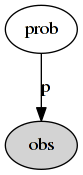

In [6]:
model = pymc.Model([prior, obs])
mcmc  = pymc.MCMC(model)

dag = pymc.graph.dag(model)
Image(dag.create_png())

## Sample the _posterior_ distribution of $p$ 

In [7]:
mcmc.sample(100000, burn=1000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 6.3 sec

## Plot the posterior trace and distribution

Plotting prob


<IPython.core.display.Javascript object>


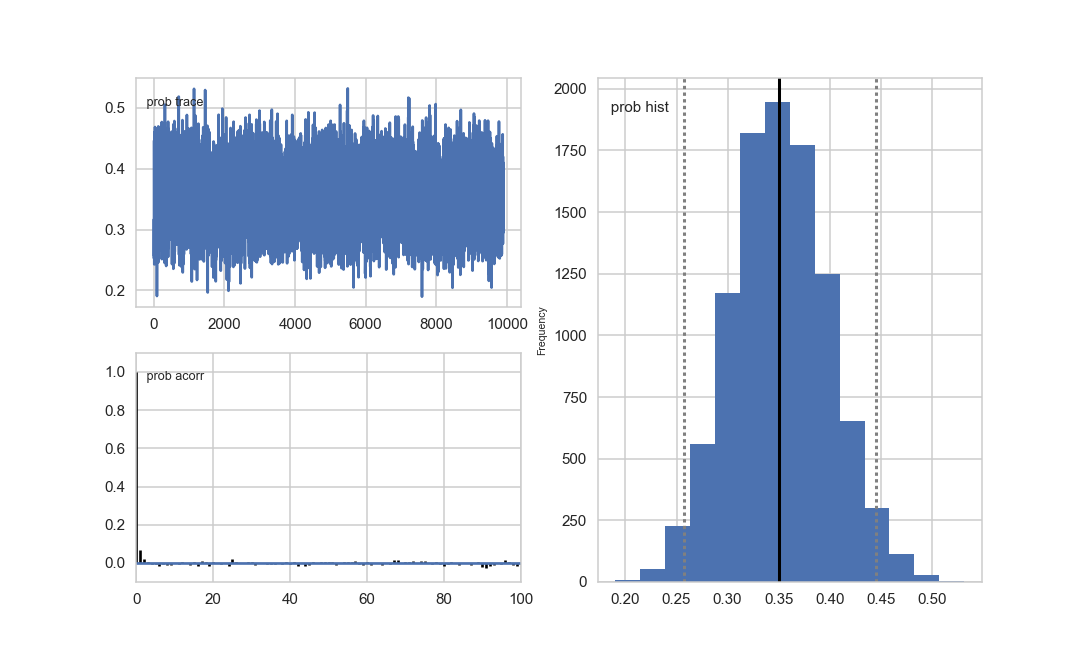

In [8]:
mcplot(mcmc.trace('prob'))
prob = mcmc.trace('prob')[:]

## Compare the Monte-Carlo results to the analytic solution

<IPython.core.display.Javascript object>


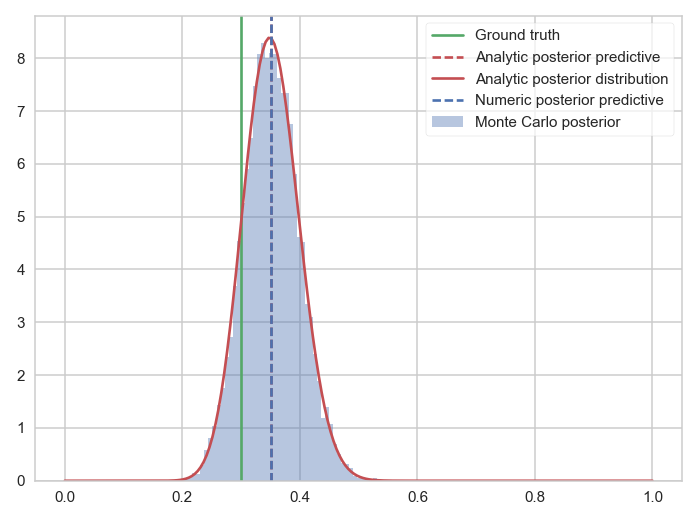

In [9]:
a_post = alpha + data.sum()
b_post =  beta + n_samples - data.sum()
p_post = a_post / (a_post + b_post)

x = np.linspace(0, 1, 200)
y_post = beta_dist.pdf(x, a_post, b_post)

fig, ax = plt.subplots(num='Numeric vs. Analytic')
sbn.distplot(prob, kde=False, norm_hist=True, ax=ax, label='Monte Carlo posterior')
ax.axvline(true_prob, color='#55a868', label='Ground truth')
ax.axvline(p_post, color='#c44e52', linestyle='dashed', label='Analytic posterior predictive')
ax.plot(x, y_post, color='#c44e52', label='Analytic posterior distribution')
ax.axvline(prob.mean(), color='#4c72b0', linestyle='dashed', label='Numeric posterior predictive')
ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.7)
fig.tight_layout()